# Support-vector machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from cvxopt import matrix, solvers

np.set_printoptions(precision=2, suppress=True)

## SVM

Минимизировать:

$$
\frac{1}{2}
\sum_{n=1}^N \sum_{m=1}^N y_n y_m \alpha_n \alpha_m x^T_n x_m - 
\sum_{n=1}^N \alpha_n
$$

где

$$
\alpha_n \geq 0
$$

$$
\sum_{n=1}^N \alpha_n y_n = 0
$$

In [2]:
def svm_solve_qp(X, y):
    N = y.shape[0]
    quadr_coeffs = np.zeros([N, N])
    for n in range(N):
        for m in range(N):
            quadr_coeffs[n][m] = y[n]*y[m]*np.dot(X[:, n], X[:, m])
    P = matrix(quadr_coeffs)
    q = matrix(np.repeat(-1, N), tc='d')
    G = matrix(np.diag(np.repeat(-1, N)), tc='d')
    h = matrix(np.repeat(0, N), tc='d')
    A = matrix(y, (1, N), tc='d')
    b = matrix(0, tc='d')
    sol = solvers.qp(P, q, G, h, A, b)
    return np.array(sol['x']).flatten()


def svm_fit(X, y, multipliers):
    w = X @ (multipliers * y)
    indices = np.where(np.logical_and(multipliers > 0.001, y > 0))[0]
    index = indices[0]
    b = np.dot(w.T, X[:, index]) - 1
    return w, b


def svm_predict(X, w, b):
    preds = w @ X + b
    return np.where(preds > 0, 1, -1)

## Линейно разделимые классы

### Генерация классов

In [23]:
N = 50
M = 10

x1 = np.random.rand(N) * M
x2 = np.random.rand(N) * M
y = np.where(x2 > x1, 1, -1)

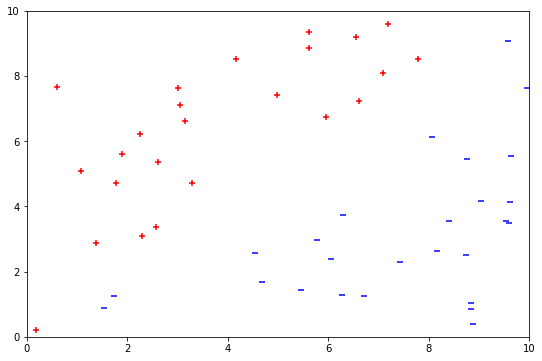

In [24]:
plt.figure(figsize=(9, 6))
plt.scatter(x1[y == 1], x2[y == 1], marker='+', color='red')
plt.scatter(x1[y == -1], x2[y == -1], marker='_', color='blue')
plt.xlim(0, M)
plt.ylim(0, M)
plt.show()

In [25]:
X = np.vstack([x1, x2])
multipliers = svm_solve_qp(X, y)
w, b = svm_fit(X, y, multipliers)

     pcost       dcost       gap    pres   dres
 0: -1.2232e+01 -2.5338e+01  2e+02  1e+01  2e+00
 1: -3.3999e+01 -3.0837e+01  7e+01  5e+00  9e-01
 2: -9.3805e+01 -8.2334e+01  7e+01  5e+00  9e-01
 3: -6.0098e+01 -5.2368e+01  8e+01  5e+00  9e-01
 4: -1.3085e+02 -1.0263e+02  9e+01  5e+00  8e-01
 5: -1.0067e+02 -5.8883e+01  1e+02  3e+00  5e-01
 6: -8.2890e+00 -1.3622e+01  3e+01  3e-01  5e-02
 7: -9.3650e+00 -1.0340e+01  3e+00  2e-02  4e-03
 8: -1.0218e+01 -1.0229e+01  3e-02  2e-04  4e-05
 9: -1.0227e+01 -1.0228e+01  3e-04  2e-06  4e-07
10: -1.0228e+01 -1.0228e+01  3e-06  2e-08  4e-09
Optimal solution found.


### График разделяющей прямой

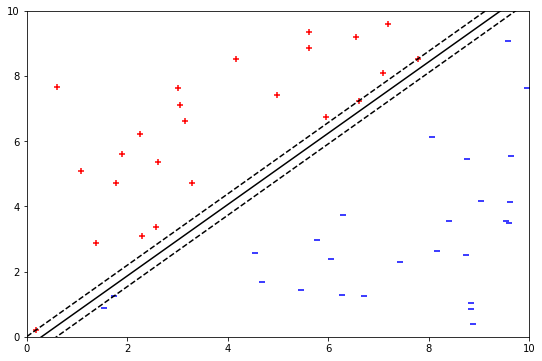

In [26]:
plt.figure(figsize=(9, 6))
plt.scatter(x1[y == 1], x2[y == 1], marker='+', color='red')
plt.scatter(x1[y == -1], x2[y == -1], marker='_', color='blue')

a = - w[0] / w[1]
xx = np.linspace(0, M)
yy = a * xx + b / w[1]

margin = 1 / np.sqrt(np.sum(w ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.xlim(0, M)
plt.ylim(0, M)

plt.show()

### Предсказание на обучающей выборке

In [27]:
preds = svm_predict(X, w, b)
(preds == y).mean()

0.92

## Линейно неразделимые классы

### Генерация классов

In [28]:
N = 100
M = 1

x1 = np.random.rand(N) * M
x2 = np.random.rand(N) * M

y = np.where(x2 < 10*(x1-0.5)**2, 1, -1)

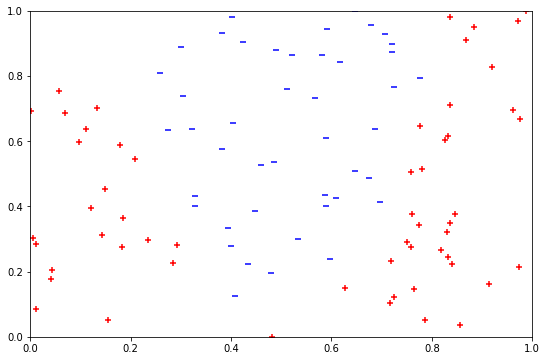

In [29]:
plt.figure(figsize=(9, 6))
plt.scatter(x1[y == 1], x2[y == 1], marker='+', color='red')
plt.scatter(x1[y == -1], x2[y == -1], marker='_', color='blue')
plt.xlim(0, M)
plt.ylim(0, M)
plt.show()

### Предсказание на обучающей выборке ("linear" kernel)

In [30]:
clf = SVC(kernel='linear')
clf.fit(np.vstack([x1, x2]).T, y.T)
preds = clf.predict(np.vstack([x1, x2]).T)

In [31]:
(preds == y).mean()

0.63

### График разделяющей прямой

In [32]:
h=.01

x_min, x_max = x1.min() - 1, x1.max() + 1
y_min, y_max = x2.min() - 1, x2.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [33]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

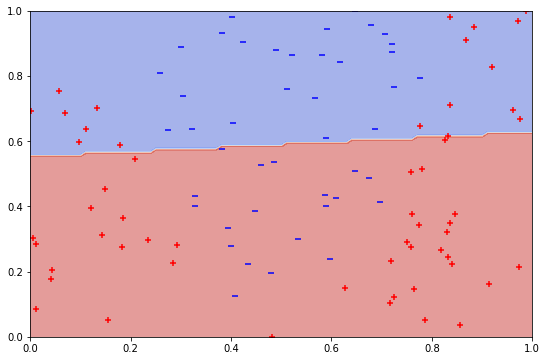

In [34]:
plt.figure(figsize=(9, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.scatter(x1[y == 1], x2[y == 1], marker='+', color='red')
plt.scatter(x1[y == -1], x2[y == -1], marker='_', color='blue')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### Предсказание на обучающей выборке ("rbf" kernel)

In [35]:
clf = SVC(kernel='rbf', gamma=1)
clf.fit(np.vstack([x1, x2]).T, y.T)
preds = clf.predict(np.vstack([x1, x2]).T)

In [36]:
(preds == y).mean()

0.88

### График разделяющей кривой

In [37]:
h=.01

x_min, x_max = x1.min() - 1, x1.max() + 1
y_min, y_max = x2.min() - 1, x2.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [38]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

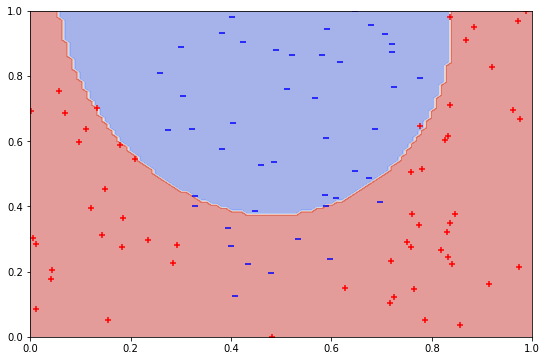

In [39]:
plt.figure(figsize=(9, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.scatter(x1[y == 1], x2[y == 1], marker='+', color='red')
plt.scatter(x1[y == -1], x2[y == -1], marker='_', color='blue')
plt.xlim(0, M)
plt.ylim(0, M)
plt.show()